<p>
    <img src="https://s3.amazonaws.com/iotanalytics-templates/Logo.png" style="float:left;">
    <h1 style="color:#1A5276;padding-left:115px;padding-bottom:0px;font-size:28px;">AWS IoT Analytics | Smart City Congestion Forecasting </h1>
</p>
<p style="color:#1A5276;padding-left:90px;padding-top:0px;position:relative;font-style:italic;font-size:18px">
Application of LSTM to predicting  the utilization rates for city highways.</p>

Forecasting is a fundamental problem in IoT systems, with forecasts feeding into many different downstream applications like vizualization, anomaly detection and planning. In this notebook, we describe how to implement and vizualize a multi-horizon, multi-series forecasting algorithm. This notebook template can be explored as-is for educational purposes, or repurposed to fit your data and deliver immediate value.


## Set-up: Import Required Notebook Libraries


This module depends on some basic Python libraries including `pandas`, `numpy`, `keras`, `tensorflow` and `matplotlib`.

In [1]:
import warnings

warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

In [2]:
# import the matrix processing library
import numpy as np

# import keras - deep neural network library
from keras.layers.merge import Add
from keras.layers.pooling import AveragePooling1D
from keras.models import Sequential
from keras.layers import LSTM,Dense,merge,LeakyReLU, Dropout, Input, RepeatVector,Reshape,Flatten
from keras.layers.core import Lambda
from keras.models import Model
from keras import backend as K
from keras.layers.merge import Concatenate

# plotting library
%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Background: Problem Description and Approach

The ability to forecast is an important consideration for IoT users when planning for their IoT device operations in the long-term. Often, businesses will want to use forecasting for multiple purposes such as predicting problems with their devices, reducing inventory costs, preparing for new opportunities and to remain competitive.

<h1 style="color:#20B3CD;font-size:20px;float:left">Step 1  |  Loading Data </h1> <div style="float:right;height:7px;background-color:#20B3CD;margin-top:30px;width:70%"></div>

### Example Dataset Description

The data is from a traffic sensor. The data describes the occupancy rate, between 0 and 1, of different car lanes. There are 963 sensors, with 10560 time stamps, where each time stamp corresponds to an interval of one hour.

Our task is to predict lane occupancy in traffic, i.e. to forecast future sensor readings. Since readings from neighbouring sensors are useful in forecasting a specific sensor, we need a multi-horizon, multi-series forecasting algorithm. Forecasts of this kind are common requirements of many systems. For example, when participating in energy demand response programs, an important first step is constructing simultaneous forecasts of energy consumption from multiple buildings, see for example http://dslab.usc.edu/dataAnalytics.php .


<p style="font-weight:bold">Dataset Attribution:</p> 
Creator: Marco Cuturi (2011), Kyoto University, mcuturi '@' i.kyoto-u.ac.jp
Source: California Department of Transportation, www.dot.ca.gov and UCI Machine Learning Repository
[http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

In order to run the algorithm on your data, set the `use_sample_dataset` variable shown below to `False`. You will also need to transform the data into a tabular format with rows corresponding to sensors and columns to time stamps. In order to need to perform get_dataset_content, you need to grant iot analytics corresponding IAM permission.

In [3]:
use_sample_dataset = True
dataset = "iot_analytics_data_set"

Now let's load data either from the IoT Analytics dataset specified in the `dataset` variable or the sample traffic sensor dataset (if `use_sample_dataset` is True or the specified IoT Analytics dataset is invalid).

In [4]:
import boto3
from six.moves.urllib import request

# create IoT Analytics client
client = boto3.client('iotanalytics')

try: # read dataset contents into a data frame
    if use_sample_dataset:
        raise Exception('Using sample data since use_sample_dataset is True')
    dataset_url = client.get_dataset_content(datasetName = dataset)['entries'][0]['dataURI']
    dataset_file = request.urlretrieve(dataset_url)[0]
    
    newA = np.empty([0,0]) # change this to correctly convert your data into a NumPy array of expected format
    
    if newA.size == 0:
        raise Exception('No data found')
except: # use sample dataset in case of any error
    newA = np.load(request.urlretrieve('https://s3.amazonaws.com/iotanalytics-templates/data/traffic_data.npy')[0])
    from IPython.display import display, Markdown
    import traceback
    display(Markdown('# <span style="color:black">{}</span>\n{}'.format('Using the sample dataset', traceback.format_exc())))

print (newA.shape)

# <span style="color:black">Using the sample dataset</span>
Traceback (most recent call last):
  File "<ipython-input-4-372e424cfed0>", line 9, in <module>
    raise Exception('Using sample data since use_sample_dataset is True')
Exception: Using sample data since use_sample_dataset is True


(963, 10560)


In [5]:
newA

array([[0.01095   , 0.00918333, 0.00891667, ..., 0.04186667, 0.03486667,
        0.027     ],
       [0.0045    , 0.004     , 0.00573333, ..., 0.02968333, 0.02443333,
        0.01561667],
       [0.01418333, 0.00985   , 0.0095    , ..., 0.05395   , 0.04738333,
        0.04918333],
       ...,
       [0.00905   , 0.0044    , 0.00358333, ..., 0.05068333, 0.03971667,
        0.03001667],
       [0.01403333, 0.01338333, 0.01803333, ..., 0.03711667, 0.03633333,
        0.03126667],
       [0.01526667, 0.01396667, 0.01685   , ..., 0.05211667, 0.04638333,
        0.04013333]])

We use the last 7 days as test data, and the remaining as training data. Splitting data like this is important to get reliable estimates of model performance and to avoid problems like overfitting.

<img src="https://s3.amazonaws.com/iotanalytics-templates/Logo.png" style="float:left;height:20px;"></img><b style="color:#1A5276;padding-left:5px;">HUMAN LEARNING NOTE:</b> The training data is structured and used for prediction and the testing data is the data that precedes the event and represents the event itself to confirm testing results. To use this template as-is you'll want to structure your training and testing data similarly.

In [6]:
# last 7 days is test data
train_data=newA[:,:(-7*24)]
test_data=newA[:,(-7*24):]

<img src="https://s3.amazonaws.com/iotanalytics-templates/Logo.png" style="float:left;height:20px;"></img><b style="color:#1A5276;padding-left:5px;">PATTERN NOTE</b> 
We consider a rolling window forecaster that uses the last 168 hours [1 week] of historical data to predict sensor readings over the next 24 hours. We use 1 week of historical data to make a forecast, because we suspect traffic data has weekly patterns. These numbers should be changed to suit your knowledge of your application.

<img src="https://s3.amazonaws.com/iotanalytics-templates/Logo.png" style="float:left;height:20px;"></img><b style="color:#1A5276;padding-left:5px;">ENVIRONMENT NOTE</b> 
Due to the size of the sample dataset, this notebook can only be executed in environments (instances) with a sufficient amount of memory, such as an `ml.m4.16xlarge` instance.

In [7]:
# these numbers will depend on how many samples of history you want to use in your application
N_HIST=168
# and how many samples into the future you want to forecast
N_PRED=24
# and how many sensors you have
max_feats=train_data.shape[0] 
# how many samples of data you have
N=train_data.shape[-1]

train_X=np.zeros((N-N_HIST-N_PRED,N_HIST,train_data.shape[0]))
train_Y=np.zeros((N-N_HIST-N_PRED,N_PRED,train_data.shape[0]))

We now convert the data into historical readings (X) and values to be forecasted (Y) for sample points.

X -> (number of samples) X (number of time steps of history used) X (number of sensors)

Y -> (number of samples) X (number of time steps to be forecasted) X (number of sensors)

In our example, we have one sensor reading every hour. We have 963 sensors, and use 1 week of history to predict readings over the next day. So, train_X will have a shape of (10200, 168, 963), corresponding to 10200 samples, over 1 week = 7*24 readings of each of 963 sensors. train_Y has a shape (10200, 24, 963) corresponding to the same number of samples and sensors, but only 1 day = 24 hours ahead

In [8]:
for i in range(N_HIST,N-N_PRED):
        train_X[i-N_HIST,:,:]=np.transpose(train_data[:,i-N_HIST:i])
        train_Y[i-N_HIST,:,:]=np.transpose(train_data[:,i:i+N_PRED])
N=test_data.shape[1]
test_X=np.zeros((N-N_PRED,N_HIST,test_data.shape[0]))
test_Y=np.zeros((N-N_PRED,N_PRED,test_data.shape[0]))

for i in range(N-N_PRED):
        j = i+train_data.shape[0]
        test_X[i,:,:]=np.transpose(newA[:,j-N_HIST:j])
        test_Y[i,:,:]=np.transpose(newA[:,j:j+N_PRED])

Why do we use 1 week of history? This is because the devices are traffic sensors, and traffic tends to display weekly patterns. So, to forecast for one day into the future, we need data from the same day last week. 

These parameters will be different in different applications, depending on the characteristics of the data and what you want to forecast.

<h1 style="color:#20B3CD;font-size:20px;float:left">Step 2  |  Look at Data </h1> <div style="float:right;height:7px;background-color:#20B3CD;margin-top:30px;width:70%"></div>

Here are a couple of examples, to show what the data looks like.

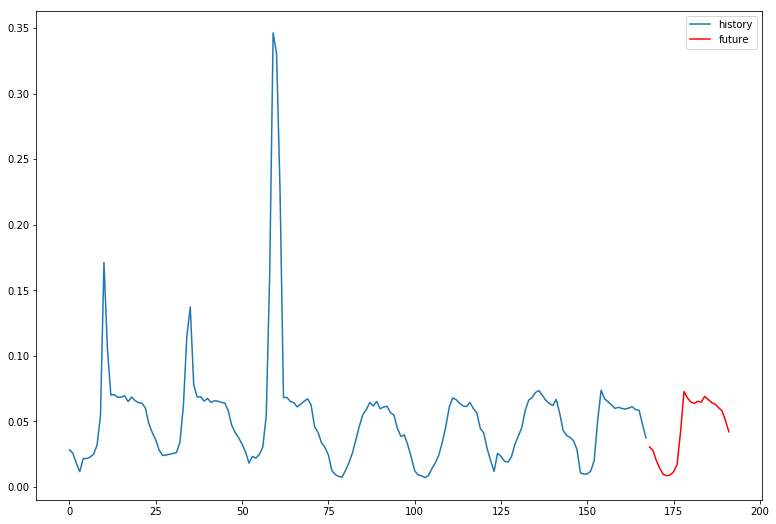

In [9]:
# we select a random sample
ind=np.random.permutation(test_X.shape[0])[0]

# Create plt figure
plt.figure(figsize=(13,9))

# we vizualize data for the first sensor on that sample
plt.plot(range(N_HIST),test_X[ind,:,0]);
plt.plot(range(N_HIST,N_HIST+N_PRED),test_Y[ind,:,0],'r');
plt.legend(['history','future']);

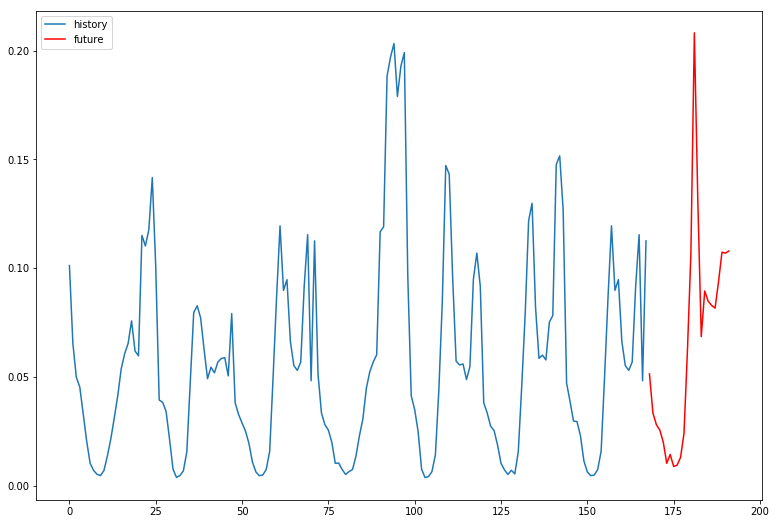

In [10]:
# we select a random sample
ind=np.random.permutation(test_X.shape[0])[0]

# Create plt figure
plt.figure(figsize=(13,9))

# we vizualize data for the third sensor on that sample
plt.plot(range(N_HIST),test_X[ind,:,3]);
plt.plot(range(N_HIST,N_HIST+N_PRED),test_Y[ind,:,3],'r');
plt.legend(['history','future']);

We will build a model to predict the future, given the history

<h1 style="color:#20B3CD;font-size:20px;float:left">Step 3  |  Deep Forecasting Model </h1> <div style="float:right;height:7px;background-color:#20B3CD;margin-top:30px;width:70%"></div>

We use a type of neural network called a  <a href="https://en.wikipedia.org/wiki/Recurrent_neural_network">Recurrent Neural Network (RNN)</a> with a type of cell called an <a href="https://en.wikipedia.org/wiki/Long_short-term_memory"> LSTM</a> to build the forecaster. A recurrent neural network is a class of artificial neural network where connections between units form a directed cycle.

<img src="https://s3.amazonaws.com/iotanalytics-templates/Logo.png" style="float:left;height:20px;"></img><b style="color:#1A5276;padding-left:5px;">PRODUCTION NOTE</b> The network has two tunable parameters, the size of the final dense layer (dense_dim) and the size of each recurrent layer (LSTM_dim). You should tune these to improve performance on your application.

In [11]:
dense_dim=80 
LSTM_dim=64

We now build the LSTM model. 

In [12]:
inputs = Input(shape=(N_HIST,max_feats), dtype='float32', name='main_input')
print(inputs.get_shape())
encoded=LSTM(LSTM_dim,return_sequences=True)(inputs) #(?,24,963)
print(encoded.get_shape())
encoded2=LSTM(LSTM_dim,return_sequences=True)(encoded) #(?,24,963)
print(encoded2.get_shape())

Lencoded=Flatten()(encoded2)
dense1=Dense(dense_dim)(Lencoded)
dense1=LeakyReLU()(dense1)
predictions=Dense(test_Y.shape[1]*test_Y.shape[2])(dense1)

LSTMModel = Model(inputs=inputs, outputs=predictions, name='LSTMModel')
LSTMModel.compile(loss='mse', optimizer='adam')

LSTMModel.summary()

(?, 168, 963)
(?, ?, 64)
(?, ?, 64)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 168, 963)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 168, 64)           263168    
_________________________________________________________________
lstm_2 (LSTM)                (None, 168, 64)           33024     
_________________________________________________________________
flatten_1 (Flatten)          (None, 10752)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 80)                860240    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 80)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2311

The code below flattens the 3d output matrix into a more managable 2d format. This is proceedural, to match the dimensions of the neural network model we built.

In [13]:
Y1_train=np.zeros((train_Y.shape[0],train_Y.shape[1]*train_Y.shape[2]))
Y1_test=np.zeros((test_Y.shape[0],test_Y.shape[1]*test_Y.shape[2]))
N1=train_Y.shape[0]
N2=train_Y.shape[1]
for i in range(N1):
    arr=train_Y[i][0]
    for j in range(1,N2):
        arr=np.concatenate([arr,train_Y[i][j]])
    Y1_train[i]=arr
N3=test_Y.shape[0]
N4=test_Y.shape[1]
for i in range(N3):
    arr=test_Y[i][0]
    for j in range(1,N4):
        arr=np.concatenate([arr,test_Y[i][j]])
    Y1_test[i]=arr

<h1 style="color:#20B3CD;font-size:20px;float:left">Step 4 | Training the model </h1> <div style="float:right;height:7px;background-color:#20B3CD;margin-top:30px;width:70%"></div>

<img src="https://s3.amazonaws.com/iotanalytics-templates/Logo.png" style="float:left;height:20px;"></img><b style="color:#1A5276;padding-left:5px;">PRODUCTION NOTE</b> The number of training epochs and the batch size can be changed to suit your application. Increasing both improve a model in general, but training it will then require more GPU or CPU memory and time.

In [14]:
history=LSTMModel.fit(train_X, Y1_train, epochs=20, batch_size=2048, verbose=1,validation_data=(test_X,Y1_test))

Train on 10200 samples, validate on 144 samples
Epoch 1/20
10200/10200 [==============================] - 41s 4ms/step - loss: 0.0047 - val_loss: 0.0035
Epoch 2/20
10200/10200 [==============================] - 38s 4ms/step - loss: 0.0036 - val_loss: 0.0021
Epoch 3/20
10200/10200 [==============================] - 40s 4ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 4/20
10200/10200 [==============================] - 38s 4ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 5/20
10200/10200 [==============================] - 38s 4ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 6/20
10200/10200 [==============================] - 38s 4ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 7/20
10200/10200 [==============================] - 38s 4ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 8/20
10200/10200 [==============================] - 39s 4ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 9/20
10200/10200 [==============================] - 38s 4ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 1

The plot below shows the train and validation loss over epochs. Both should decrease if training goes as expected.

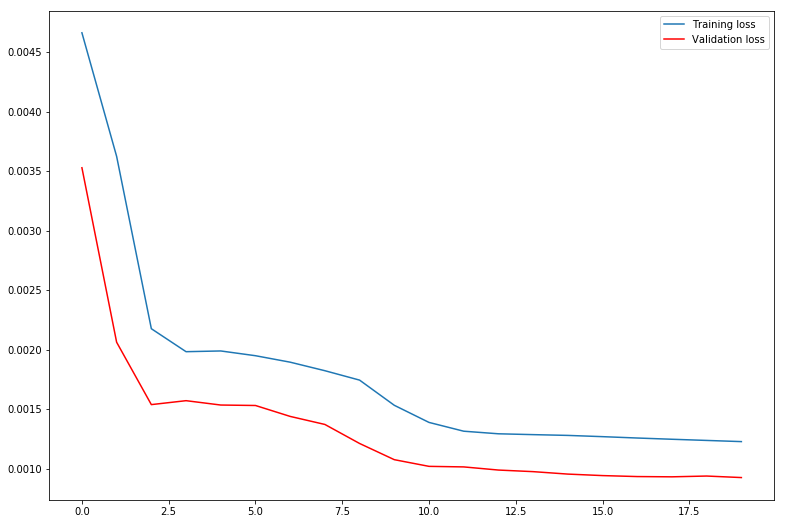

In [15]:
# Create plt figure
plt.figure(figsize=(13,9))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'],'r')
plt.legend(['Training loss','Validation loss'])

<h1 style="color:#20B3CD;font-size:20px;float:left">Step 5 | Generating and Visualizing the predictions </h1> <div style="float:right;height:7px;background-color:#20B3CD;margin-top:30px;width:70%"></div>

In [16]:
# predict on test data using the learned model
pred=LSTMModel.predict(test_X)

In [17]:
# for visualization, we convert the flattened predictions back into our original 3d shape
nY=np.reshape(pred,test_Y.shape)

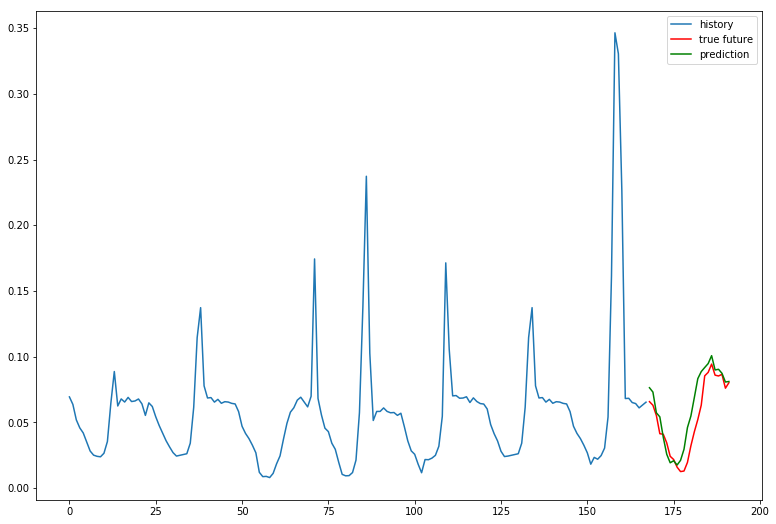

In [18]:
# as before, we select a random test sample
ind=np.random.permutation(test_X.shape[0])[0]

# Create plt figure
plt.figure(figsize=(13,9))

# we also pick a random sensor
sen=np.random.permutation(test_X.shape[0])[-1]
plt.plot(range(N_HIST),test_X[ind,:,0]);
plt.plot(range(N_HIST,N_HIST+N_PRED),test_Y[ind,:,sen],'r');
plt.plot(range(N_HIST,N_HIST+N_PRED),nY[ind,:,sen],'g');
plt.legend(['history','true future','prediction'])

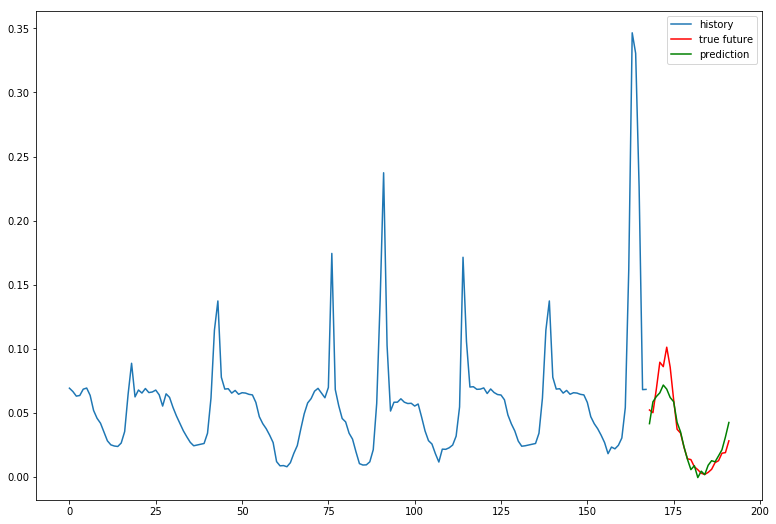

In [19]:
# another one
ind=np.random.permutation(test_X.shape[0])[0]
sen=np.random.permutation(test_X.shape[0])[-1]

# Create plt figure
plt.figure(figsize=(13,9))

plt.plot(range(N_HIST),test_X[ind,:,0]);
plt.plot(range(N_HIST,N_HIST+N_PRED),test_Y[ind,:,sen],'r');
plt.plot(range(N_HIST,N_HIST+N_PRED),nY[ind,:,sen],'g');
plt.legend(['history','true future','prediction'])

We see that the model is able to learn daily patterns and, to some extent, weekly patterns. With more data and longer training the models can be made even better. 

It is important to note that these forecasting metrics will change with new data and different model parameters, so testing is encouraged.

To summarize, in this notebook we ingested some IoT data about traffic sensors and predicted the lane occupancy for a given day. This notebook demonstrates how we can use machine learning to help in the IoT industry by forecasting sensor data in the immediate future using the historical data from the sensor.

<div style="height:60px;"><div style="height:7px;background-color:#20B3CD;width:100%;margin-top:20px;position:relative;"><img src="https://s3.amazonaws.com/iotanalytics-templates/Logo.png" style="height:50px;width:50px;margin-top:-20px;position:absolute;margin-left:42%;"></div></div>